# 获取原始数据

In [1]:
import os
import sys
import talib as ta
syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import talib as ta
from dateutil.parser import parse
import numpy as np
# run if simulation file is updated
importlib.reload(sim)

HOST = "mongodb://172.16.20.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

from datetime import datetime
import time
d1 = datetime(2021,5,10, 9)
d2 = datetime(2021,11,10,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

# print(d1.timetuple())
# print(time.mktime(d1.timetuple()))
# print(int(time.mktime(d1.timetuple())))

# swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)
swapdata = source.swap_by_time("SWAP_WBTC_WETH_3000", t1, t2)
swapdata.tail()
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
# pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(8, 18).x96_to_price)
pricedata['datetime']  = pd.to_datetime(pricedata['timestamp'],unit='s')
pricedata['datetime'] = [str(tmp)[:] for tmp in pricedata['datetime'].tolist()]
pricedata

,timestamp,sqrtPriceX96,price,datetime
0,1620608457,30685129890900272086470739815588235,15.000190,2021-05-10 01:00:57
1,1620608457,30709533659969384051347723595723166,15.024059,2021-05-10 01:00:57
2,1620608592,30705863068469425277565093729731105,15.020468,2021-05-10 01:03:12
3,1620608683,30724919029063427727612188810824282,15.039117,2021-05-10 01:04:43
4,1620608715,30722150531496348621299112840911173,15.036406,2021-05-10 01:05:15
...,...,...,...,...
48906,1636503509,29774922511961089343557287689272623,14.123493,2021-11-10 00:18:29
48907,1636503788,29777538572175576629925813454628677,14.125975,2021-11-10 00:23:08
48908,1636503867,29779112171410890340359447285519816,14.127468,2021-11-10 00:24:27
48909,1636503933,29785324667474397808596827643830253,14.133363,2021-11-10 00:25:33


In [2]:
pricedata['datetime'].tolist()[0]

'2021-05-10 01:00:57'

<AxesSubplot:xlabel='datetime'>

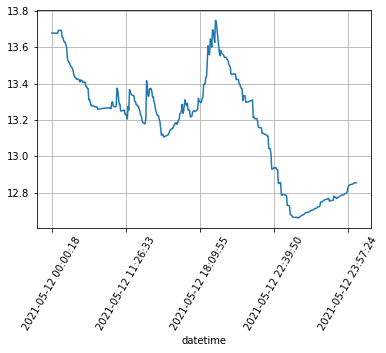

In [3]:
pricedata_plot = pricedata.copy(deep=True)
pricedata_plot = pricedata_plot[pricedata_plot['datetime']<'2021-05-13 00:00:00']
pricedata_plot = pricedata_plot[pricedata_plot['datetime']>'2021-05-12 00:00:00']
pricedata_plot = pricedata_plot[pricedata_plot['datetime']>'2021-05-12 00:00:00']
pricedata_plot.set_index('datetime')['price'].plot(rot = 60,grid=True)
# pricedata_plot.set_index('datetime')['price'].plot(rot = 60)
# pricedata_plot[pricedata_plot['datetime']<'2021-05-15 00:00:00'].set_index('datetime')['price'].plot(rot = 60)

# 指标计算arRollNorm

In [4]:
import pickle
from scipy import stats
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
symbolSigDataAR = load_obj('ARdata/symbolsSigAvg_2018050120211124_60min_v18_ar')['60min']

# AR Rolling Normalization ####################################################
def normalizationProcess(dataArray):
    q75 = np.quantile(dataArray, 0.75)
    q50 = np.quantile(dataArray, 0.5)
    q25 = np.quantile(dataArray, 0.25)
    scaleResult = 100*stats.norm.cdf(0.5*(dataArray[-1]-q50)/(q75-q25))-50
    return scaleResult

def get_ar_norm(df,arCol,WinSize):
    arRollNorm = df[arCol].dropna().rolling(WinSize).apply(normalizationProcess)
    return arRollNorm

ar_param = 144
winsize = 288
symbolSigDataAR[f'arRollNorm{winsize}'] = get_ar_norm(symbolSigDataAR,f'ar{ar_param}',winsize)

startInd = f'{d1.year}-{d1.month}-{d1.day}'
symbolSigDataARRollNorm = symbolSigDataAR.loc[startInd:]
symbolSigDataARRollNormSub = symbolSigDataARRollNorm.reset_index()[[('timestamp',''),(f'arRollNorm{winsize}','')]]
symbolSigDataARRollNormSub.columns = ['datetime',f'arRollNorm{winsize}']
symbolSigDataARRollNormSub['price'] = [np.nan]*len(symbolSigDataARRollNormSub)
symbolSigDataARRollNormSub['sqrtPriceX96'] = [np.nan]*len(symbolSigDataARRollNormSub)
symbolSigDataARRollNormSub['timestamp'] = [np.nan]*len(symbolSigDataARRollNormSub)
symbolSigDataARRollNormSub = symbolSigDataARRollNormSub[['timestamp','sqrtPriceX96','price','datetime',f'arRollNorm{winsize}']]
symbolSigDataARRollNormSub.index = [i for i in range(len(pricedata),len(pricedata)+len(symbolSigDataARRollNormSub))]
symbolSigDataARRollNormSub

pricedataExtend = pricedata.copy(deep=True)
pricedataExtend[f'arRollNorm{winsize}'] = [np.nan]*len(pricedataExtend)
pricedataExtend

datetimeTmp = symbolSigDataARRollNormSub['datetime'].tolist()
datetimeNew = [str(dt)[:-6] for dt in datetimeTmp]
symbolSigDataARRollNormSub['datetime'] = datetimeNew
bar = pricedataExtend.append(symbolSigDataARRollNormSub)

bar = bar.sort_values(by='datetime')
# bar.fillna(method='ffill')
bar = bar.fillna(method='ffill')
pricedata_res_arRollNorm = bar.loc[pricedataExtend.index]
pricedata_res_arRollNorm.set_index('datetime',inplace=True)
pricedata_res_arRollNorm = pricedata_res_arRollNorm[[f'arRollNorm{winsize}']]
pricedata_res_arRollNorm

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#之后要扩展回测区间时，需要更新此处的基本行情数据
df_eth = load_obj('../../data/usdceth/symbolsData_2018032120211116_60min_v16_E')['60min']
df_eth.columns= ['open','high','low','close','volume']
df_eth = df_eth.loc['2018-03-22':'2021-11-09']
df_eth.reset_index(inplace=True)
df_eth.columns = ['datetime','open','high','low','close','volume']
def cal_indicator(dataCoin):    
    dataCoin['pctChange'] = dataCoin['close'].pct_change()
    dataCoin['pctStd'] = ta.STDDEV(dataCoin['pctChange'], 24*5)*(24**0.5)
    dataCoin['pctStdVma'] = ta.SUM(dataCoin['pctStd']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['closeVma'] = ta.SUM(dataCoin['close']*dataCoin['volume'], 24*50) / ta.SUM(dataCoin['volume'], 24*50)
    dataCoin['pctStdVSma'] = ta.EMA(dataCoin.pctStdVma, 24*3)
    dataCoin['pctStdVLma'] = ta.MA(dataCoin.pctStdVma, 24*10)
    dataCoin['SmaLowerLma'] = dataCoin['pctStdVSma']<dataCoin['pctStdVLma']
    dataCoin['CloseLowerMA'] = dataCoin['close'] < dataCoin['closeVma']
    #根据volResearch notebook里的BelowMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolLowerBelowmaQuantile50'] = dataCoin['pctStd'] < 0.035857 
    #根据volResearch notebook里的OverMA的vol stat中quantile50的2018.5至2021.5波动率统计得出
    dataCoin['VolHigherOvermaQuantile50Twosigma'] = dataCoin['pctStd'] > (0.038511 + 2*0.018451)
    #当波动率高于Belowma的vol stat中的Quantile50的1.05倍时撤销池子
    dataCoin['revoke_pos'] = dataCoin['pctStd'] > 0.035857 *1.05
    
cal_indicator(df_eth)

df_eth_test_period = df_eth[df_eth['datetime']>parse('2021-05-10 00:00:00+00:00')]
df_signal_tmp = df_eth_test_period[['datetime',
                               'SmaLowerLma',
                               'VolLowerBelowmaQuantile50',
                               'CloseLowerMA',
                               'VolHigherOvermaQuantile50Twosigma',
                               'revoke_pos']]
df_signal_tmp['timestamp'] = [0]*len(df_signal_tmp)
df_signal_tmp['sqrtPriceX96'] = [0]*len(df_signal_tmp)
df_signal_tmp['price'] = [0]*len(df_signal_tmp)

df_signal_tmp = df_signal_tmp[['timestamp','sqrtPriceX96','price','datetime',
                 'SmaLowerLma',
                 'VolLowerBelowmaQuantile50',
                 'CloseLowerMA',
                 'VolHigherOvermaQuantile50Twosigma',
                 'revoke_pos']]
df_signal_tmp['datetime_2'] = df_signal_tmp['datetime']
df_signal_tmp = df_signal_tmp.set_index('datetime_2')
# df_signal_tmp = df_signal_tmp.resample('D').first()
df_signal_tmp['datetime'] = [str(tmp)[:-6] for tmp in df_signal_tmp['datetime'].tolist()]
df_signal_tmp['ind'] = [i for i in range(len(pricedata),len(pricedata)+len(df_signal_tmp))]
df_signal_tmp.set_index('ind',inplace=True)
pricedata_tmp = pricedata.append(df_signal_tmp)
pricedata_tmp = pricedata_tmp.sort_values(by='datetime')
pricedata_tmp_beforefill = pricedata_tmp.copy(deep = True)
pricedata_tmp = pricedata_tmp.fillna(method = 'ffill')
pricedata_res = pricedata_tmp.loc[pricedata.index]
pricedata_res.set_index('datetime',inplace=True)

pricedata_res[f'arRollNorm'] = pricedata_res_arRollNorm[f'arRollNorm{winsize}']
pricedata_res

,timestamp,sqrtPriceX96,price,SmaLowerLma,VolLowerBelowmaQuantile50,CloseLowerMA,VolHigherOvermaQuantile50Twosigma,revoke_pos,arRollNorm
datetime,,,,,,,,,
2021-05-10 01:00:57,1620608457,30685129890900272086470739815588235,15.000190,False,False,False,False,True,-15.211088
2021-05-10 01:00:57,1620608457,30709533659969384051347723595723166,15.024059,False,False,False,False,True,-15.211088
2021-05-10 01:03:12,1620608592,30705863068469425277565093729731105,15.020468,False,False,False,False,True,-15.211088
2021-05-10 01:04:43,1620608683,30724919029063427727612188810824282,15.039117,False,False,False,False,True,-15.211088
2021-05-10 01:05:15,1620608715,30722150531496348621299112840911173,15.036406,False,False,False,False,True,-15.211088
...,...,...,...,...,...,...,...,...,...
2021-11-10 00:18:29,1636503509,29774922511961089343557287689272623,14.123493,True,True,False,False,False,-43.820580
2021-11-10 00:23:08,1636503788,29777538572175576629925813454628677,14.125975,True,True,False,False,False,-43.820580
2021-11-10 00:24:27,1636503867,29779112171410890340359447285519816,14.127468,True,True,False,False,False,-43.820580


# 回测

In [5]:
init_price = pricedata_res["price"][0]

decimal0 = 8 #BTC的精度
decimal1 = 18 #ETH的精度

init_amount0 = 10*1e8 #初始持有BTC的数量
init_amount1 = 0 #初始持有ETH的数量
print('init_price =',init_price)

init_price = 15.000190153257385


# 建池撤池详细信息

In [6]:
import Strategy_btceth_vol_ar_v1
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(Strategy_btceth_vol_ar_v1)
strategy = Strategy_btceth_vol_ar_v1.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, True)
strategy.init(swapdata.iloc[0].to_dict())

# strategy.run(swapdata, priceDt)
strategy.run(swapdata, pricedata_res)

report = strategy.report()

**********************【Price Over MA】【创建Long Vol池子】【第1次建池】***********************************
转换后钱包中余额 amount0:  449725000.0 amount1:  75596125164807241728
price:  13.747580536205303
$$$$$$$【Upper Price】: 17.727388507545324
$$$$$$$【Lower Price】: 10.661241531374369
######【L】:1397595515309502【BTC】:449725000【ETH】:62230877145216147456
将要投入池子的数量 amount_t0: 449725000 amount_t1: 62230877145216147456
【RealWorldTime】:2021-06-04 06:52:40, Timestamp: 1622760760, Blocknumber: 12564328
Mint position： Position(L=1397030982737294, tick=[253920, 259020], range=[0.0564, 0.0940])
【Mint amount】: token0=4.49360486, token1=62.23087714521611
Wallet amount: token0=0.00364514, token1=13.365248019591126
******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: True, VolHigherQuantile50TwoSigma: False,arRollNorm:-5.3800103061215125
Price(13.731235286903543) out of range(10.661241531374369, 17.727388507545324)
【RealWorldTime】:2021-06-04

******************************************【撤销池子】【原因:OverMA与VolHigherQuantile50TwoSigma条件不满足】****************************
CloseLowerMA: False, VolHigherQuantile50TwoSigma: False,arRollNorm:5.937236525245737
Price(13.676939859392697) out of range(11.658498803763855, 19.385616309400998)
【RealWorldTime】:2021-09-08 06:42:23,Timestamp: 1631054543, Blocknumber: 13181399
Decreased position： Position(L=0, tick=[254820, 259860], range=[0.0519, 0.0859])
【Decreased amount】: token0=6.58515625, token1=43.65503053380508
Wallet amount: token0=6.58515627, token1=59.4262040832413
撤池后经转换 Wallet amount: token0=10.72656097, token1=2.9461435176848765
**********************【Price Over MA】【创建Long Vol池子】【第9次建池】***********************************
转换后钱包中余额 amount0:  482400264.0 amount1:  84641915240660845569
price:  13.841865494217123
$$$$$$$【Upper Price】: 17.848968161266303
$$$$$$$【Lower Price】: 10.734359467108025
######【L】:1509334721288052【BTC】:482400264【ETH】:67660832450033631232
将要投入池子的数量 amount_t0: 482400263

# 获取原始绩效指标

In [7]:
positions = report.positions
positions

{1: <univ3api.simulation.PositionReport at 0x2c9f04dd040>,
 2: <univ3api.simulation.PositionReport at 0x2c9f7c2ae20>,
 3: <univ3api.simulation.PositionReport at 0x2c9f7be96a0>,
 4: <univ3api.simulation.PositionReport at 0x2c9f7be9d00>,
 5: <univ3api.simulation.PositionReport at 0x2c9f1c20520>,
 6: <univ3api.simulation.PositionReport at 0x2c9f1c20a00>,
 7: <univ3api.simulation.PositionReport at 0x2c9f1c20fa0>,
 8: <univ3api.simulation.PositionReport at 0x2c9f7be9be0>,
 9: <univ3api.simulation.PositionReport at 0x2c9f5886dc0>,
 10: <univ3api.simulation.PositionReport at 0x2c9f58a05e0>,
 11: <univ3api.simulation.PositionReport at 0x2c9f58a0ac0>,
 12: <univ3api.simulation.PositionReport at 0x2c9f58a0fa0>,
 13: <univ3api.simulation.PositionReport at 0x2c9f1cd27c0>,
 14: <univ3api.simulation.PositionReport at 0x2c9f1cd2e20>,
 15: <univ3api.simulation.PositionReport at 0x2c9f1ce3640>,
 16: <univ3api.simulation.PositionReport at 0x2c9f1ce3a30>,
 17: <univ3api.simulation.PositionReport at 0x2c9

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-07-27 11:24:13,4.235437,0.000000,0.000000,0.000000,73.379536,0.000000e+00,0.000000e+00,0.000000e+00
1,2021-07-27 12:10:48,4.235437,0.000000,0.000000,0.000000,73.379547,5.560483e-09,5.560483e-09,5.560483e-09
2,2021-07-27 12:14:33,4.272019,0.000018,0.000018,0.000018,72.761982,0.000000e+00,5.560483e-09,5.560483e-09
3,2021-07-27 12:31:50,4.257508,0.000000,0.000018,0.000018,73.006805,1.224116e-04,1.224172e-04,1.224172e-04
4,2021-07-27 12:46:20,4.245878,0.000000,0.000018,0.000018,73.20315,9.817236e-05,2.205896e-04,2.205896e-04
...,...,...,...,...,...,...,...,...,...
261,2021-07-28 08:21:13,4.061540,0.000000,0.000203,0.000203,76.332527,5.065602e-08,4.904273e-03,4.904273e-03
262,2021-07-28 08:21:45,4.051914,0.000000,0.000203,0.000203,76.496834,8.215391e-05,4.986427e-03,4.986427e-03
263,2021-07-28 08:21:45,4.051590,0.000000,0.000203,0.000203,76.50237,2.767569e-06,4.989194e-03,4.989194e-03
264,2021-07-28 08:33:20,4.050292,0.000000,0.000203,0.000203,76.524526,1.107828e-05,5.000272e-03,5.000272e-03


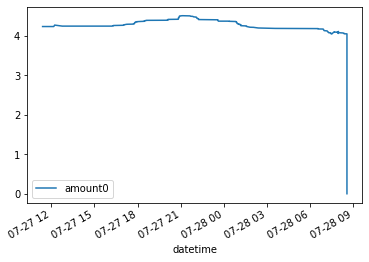

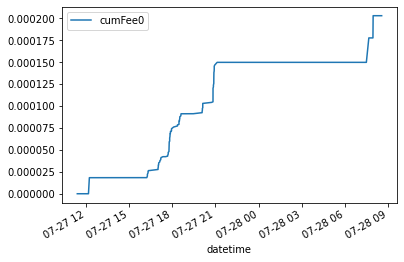

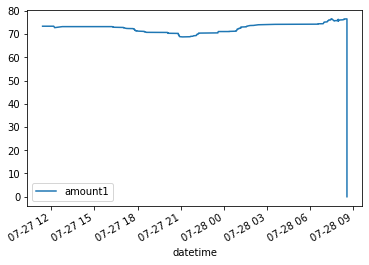

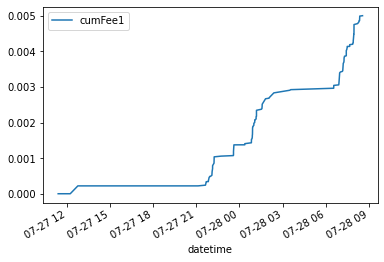

In [8]:
positions[5].get_balance(plain=True, draw_plot=True)

In [9]:
total_balance = report.total_balance(draw_plot=False, plain=True)
backtest_report = total_balance.copy(deep=True)

<AxesSubplot:title={'center':'Total Balance'}>

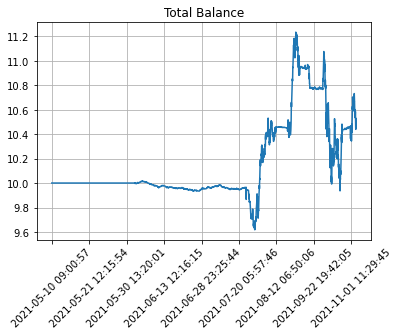

In [10]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price
btc_balance = total_balance.set_index("timestamp")[["amount0NoFee", "cumFee0"]].sum(axis=1)
eth_balance = total_balance.set_index("timestamp")[["amount1NoFee", "cumFee1"]].sum(axis=1) / price
eth_balance+btc_balance
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (eth_balance+btc_balance)
tb_Timing_origin = tb_Timing.copy(deep=True)
time_to_print = list(map(time.localtime,tb_Timing.index.tolist()))
time_to_print_2  = [time.strftime('%Y-%m-%d %H:%M:%S', i) for i in time_to_print]
# time_to_print_2  = [time.strftime('%Y-%m-%d', i) for i in time_to_print]
tb_Timing.index = time_to_print_2
tb_Timing.plot(rot = 45,grid=True,title='Total Balance')
# tb_Timing.to_csv('../../data/usdceth/tb_timing_v2.csv')
# tb_Timing_origin.to_csv('../../data/usdceth/tb_timing_origin_v2.csv')

In [11]:
eth_balance
eth_balance_df = pd.DataFrame(eth_balance)
eth_balance_df.columns = ['eth_balance']
eth_balance_df

,eth_balance
timestamp,
1620608457,0.000000
1620608592,0.000000
1620608683,0.000000
1620608715,0.000000
1620608967,0.000000
...,...
1636503509,5.794262
1636503788,5.796647
1636503867,5.798082


In [12]:
btc_balance
btc_balance_df = pd.DataFrame(btc_balance)
btc_balance_df.columns = ['btc_balance']
btc_balance_df

,btc_balance
timestamp,
1620608457,10.000000
1620608592,10.000000
1620608683,10.000000
1620608715,10.000000
1620608967,10.000000
...,...
1636501511,4.680434
1636503509,4.672297
1636503788,4.668895


In [13]:
tb_Timing

2021-05-10 09:00:57    10.000000
2021-05-10 09:03:12    10.000000
2021-05-10 09:04:43    10.000000
2021-05-10 09:05:15    10.000000
2021-05-10 09:09:27    10.000000
                         ...    
2021-11-10 08:18:29    10.466559
2021-11-10 08:23:08    10.465542
2021-11-10 08:24:27    10.464930
2021-11-10 08:25:33    10.462514
2021-11-10 08:46:58          NaN
Length: 40646, dtype: float64

# 计算绩效指标

In [14]:
# tb_Timing.resample('D').sum()
pd.to_datetime(tb_Timing.index.tolist()[0])
tb_Timing.index = pd.to_datetime(tb_Timing.index)
tb_Timing.resample('D').last()

2021-05-10    10.000000
2021-05-11    10.000000
2021-05-12    10.000000
2021-05-13    10.000000
2021-05-14    10.000000
                ...    
2021-11-06    10.589729
2021-11-07    10.729095
2021-11-08    10.564258
2021-11-09    10.516645
2021-11-10    10.462514
Freq: D, Length: 185, dtype: float64

In [15]:
df_tb = pd.DataFrame(tb_Timing.resample('D').last(),columns=['close'])
df_tb['return'] = df_tb['close'].pct_change()
df_tb['return_2'] = df_tb['close']/df_tb['close'].shift(1) - 1
df_tb = df_tb.iloc[:-1,:]
df_tb

,close,return,return_2
2021-05-10,10.000000,NaN,NaN
2021-05-11,10.000000,0.000000,0.000000
2021-05-12,10.000000,0.000000,0.000000
2021-05-13,10.000000,0.000000,0.000000
2021-05-14,10.000000,0.000000,0.000000
...,...,...,...
2021-11-05,10.645872,-0.002388,-0.002388
2021-11-06,10.589729,-0.005274,-0.005274
2021-11-07,10.729095,0.013161,0.013161
2021-11-08,10.564258,-0.015364,-0.015364


<AxesSubplot:>

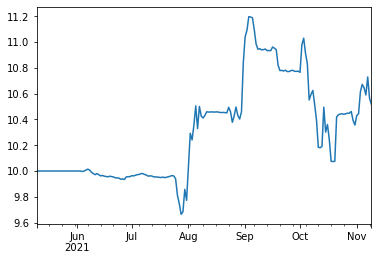

In [16]:
df_tb['close'].plot()

In [17]:
from scipy.stats.mstats import gmean
import math
def max_drawdown(df):
    """
    :return: Max drawdown of the financial series.
    """
    roll_max = df['close'].expanding().max()
    maxDrawdown = -1 * np.min(df['close'] / roll_max - 1)  # 计算得到最大回撤
    return maxDrawdown

def annual_return(df):
    """
    :return: Annual return.
    """
    annualReturn = gmean(df['return'].dropna() + 1) ** 365 - 1  # 得到年化收益率
    return annualReturn

def annual_std(df):
    """
    :return: The annual standard deviation.
    """
    dailyStd = df['return'].std()  # 得到日度波动率
    annualStd = dailyStd * math.sqrt(365)  # 得到年化波动率
    return annualStd

def sharpe_ratio(df):
    """
    :return:  Sharpe ratio.
    """
    annualReturn = annual_return(df)
    annualStd = annual_std(df)
    sharpeRatio = annualReturn / annualStd  # 得到夏普比
    return sharpeRatio

def calmar_ratio(df):
    """
    :return: Calmar ratio.
    """
    annualReturn = annual_return(df)
    maxDrawdown = max_drawdown(df)
    calmarRatio = annualReturn / maxDrawdown
    return calmarRatio

def max_drawdown_duration(df):
    """
    :return: Max Drawdown duration
    """
    xdate = df_tb.index.tolist()
    ycapital = df_tb['close'].tolist()
    duration = []
    tmp_max_capital = ycapital[0]
    for c in ycapital:
        if c >= tmp_max_capital:
            duration.append(0)
        else:
            duration.append(duration[-1]+1)
        tmp_max_capital = max(c, tmp_max_capital)
    MaxDDD = max(duration)
    endidx = np.argmax(duration)
    startidx = endidx - MaxDDD
#     print(xdate[startidx])
#     print(xdate[endidx])
    startD = xdate[startidx]
    endD = xdate[endidx]
#     return MaxDDD, startidx, endidx
    return MaxDDD, startD,endD
    


# 输出绩效

【SWAP_BTC_WETH_3000】

BTC手续费 0.0184572 ETH手续费(BTC计价) 0.017866460813856167
***************************资金曲线绩效***************************
最大回撤 0.1003276020737286
最长回撤持续期 67 日 起始日期 2021-09-03 00:00:00 结束日期 2021-11-09 00:00:00
年化收益 0.10569378610908386
夏普比率 0.7107559405567302
卡尔玛比率 1.0534866170868091


<AxesSubplot:title={'center':'Total Balance'}>

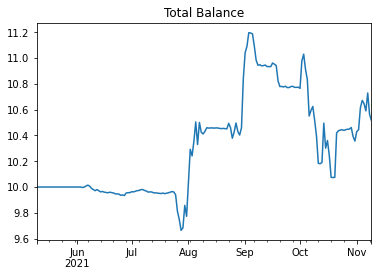

In [18]:
print('【SWAP_BTC_WETH_3000】')
print()

cumfee0 = backtest_report['cumFee0'].tolist()[-1]
cumfee1 = backtest_report['cumFee1'].tolist()[-1]/pricedata_res['price'].tolist()[-1]
print('BTC手续费',cumfee0,'ETH手续费(BTC计价)',cumfee1)
print('***************************资金曲线绩效***************************')
print('最大回撤',max_drawdown(df_tb))
print('最长回撤持续期',max_drawdown_duration(df_tb)[0],'日',
      '起始日期',max_drawdown_duration(df_tb)[1],
      '结束日期',max_drawdown_duration(df_tb)[2])
print('年化收益',annual_return(df_tb))
print('夏普比率',sharpe_ratio(df_tb))
print('卡尔玛比率',calmar_ratio(df_tb))
df_tb['close'].plot(title='Total Balance')